In [9]:
from nltk.tokenize import wordpunct_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
import json

In [10]:
articles = []
with open("ai_in_finance.json", "r") as f:
    for line in f:
        try:
            article = json.loads(line)
            articles.append(article)
        except json.JSONDecodeError as e:
            print(f"skip the error: {e}")

# Check
print(f"success load {len(articles)} articles")

success load 4384 articles


In [11]:
#%% Convert to DataFrame (assuming each article has "text" and "year")
df = pd.DataFrame(articles)
df = df[df['text'].str.strip().astype(bool)]  # remove empty texts

In [13]:
# Assuming you have a DataFrame `df` with a column 'text'
documents = [TaggedDocument(words=wordpunct_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(df['text'])]

In [41]:
model = Doc2Vec(vector_size=128, 
                window=5, 
                min_count=1, 
                workers=4, 
                epochs=100)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [42]:
doc_vectors = [model.infer_vector(wordpunct_tokenize(doc.lower())) for doc in df['text']]

In [45]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import numpy as np

doc_vectors_np = np.array(doc_vectors)

#pca = PCA(n_components=2, random_state=38)
#tsne = TSNE(n_components=2, random_state=38, perplexity=30)
umap = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=38)

reduced_vectors = umap.fit_transform(doc_vectors_np)

/opt/anaconda3/envs/NLP/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/NLP/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [46]:
# Create plotting DataFrame
df_plot = pd.DataFrame(reduced_vectors, columns=["x", "y"])
df_plot["year"] = df["date"]
df_plot["year"] = pd.to_datetime(df_plot["year"].apply(lambda x: x["$date"]), errors="coerce").dt.year

In [47]:
df_plot

,x,y,year
0,11.708738,8.255775,2016
1,10.902077,2.996666,2014
2,11.894300,7.602663,2016
3,13.570228,2.478981,2014
4,6.797706,3.751813,2015
...,...,...,...
4379,11.679014,7.131390,2016
4380,13.396882,0.053932,2012
4381,9.990929,7.719680,2015
4382,10.040065,7.113543,2018


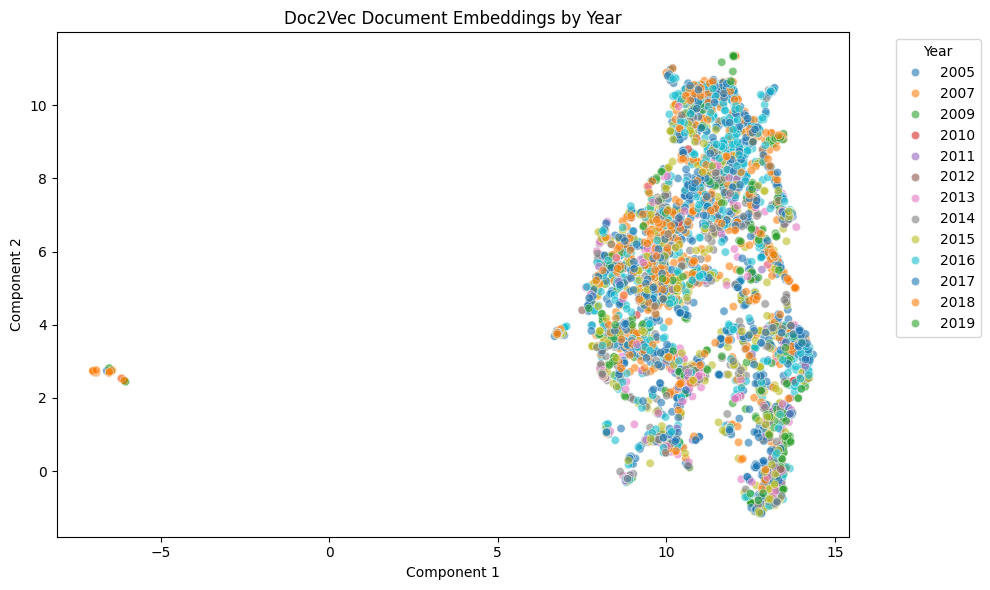

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='year', palette='tab10', alpha=0.6)

plt.title("Doc2Vec Document Embeddings by Year")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
